In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Quick data visualization

First let's see how our images look like:

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img



base_path = "/content/drive/My Drive/COVID-19_Radiography_Dataset"


classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]


if not classes:
    print("❌ Aucun sous-dossier trouvé, vérifiez le dataset.")
else:
    print(f"📂 Classes détectées : {classes}")

    plt.figure(figsize=(12, 6))
    images_found = 0

    # Afficher une image par classe
    for i, class_name in enumerate(classes):
        images_path = os.path.join(base_path, class_name)  # Prendre uniquement les images
        if not os.path.exists(images_path):
            print(f"⚠ Pas de dossier 'images' trouvé pour {class_name}")
            continue

        # Lister les fichiers images
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            img_path = os.path.join(images_path, image_files[0])
            img = load_img(img_path, target_size=(224, 224))

            plt.subplot(1, len(classes), images_found + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

            images_found += 1

    if images_found > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image trouvée dans les classes.")


📂 Classes détectées : ['Lung_Opacity', 'Normal', 'COVID', 'Viral Pneumonia', 'train', 'test']
❌ Aucune image trouvée dans les classes.


<Figure size 1200x600 with 0 Axes>

In [ ]:

for expression in os.listdir(base_path + "/train"):
    print(str(len(os.listdir(base_path+ "/train/" + expression))) + " " + expression + " images")

6014 Lung_Opacity images
9782 Normal images
3480 COVID images
1293 Viral Pneumonia images


In [ ]:

import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📂 Chemin du dossier d'entraînement
train_dir = "/content/drive/My Drive/COVID-19_Radiography_Dataset/train"

classes = os.listdir(train_dir)
data = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = [
        os.path.join(class_name, img)
        for img in os.listdir(class_path)
        if img.endswith(('png', 'jpg', 'jpeg'))
    ]
    data.extend([(img, class_name) for img in images])


df = pd.DataFrame(data, columns=["filename", "class"])


min_samples = df['class'].value_counts().min()
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


pic_size = 224
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    df_balanced,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(pic_size, pic_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


print("📊 Nouvelle distribution des classes :\n", df_balanced['class'].value_counts())


<ipython-input-4-af226ed1a94c>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


Found 5172 validated image filenames belonging to 4 classes.
📊 Nouvelle distribution des classes :
 class
COVID              1293
Lung_Opacity       1293
Normal             1293
Viral Pneumonia    1293
Name: count, dtype: int64


The image expressions in our training dataset are pretty balanced, except for the 'disgust' category.

Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_model():
  model = Sequential([
      Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
      MaxPooling2D(2,2),
      Dropout(0.3),

      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2,2),
      Dropout(0.4),

      Flatten(),
      Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
      Dropout(0.5),
      Dense(4, activation='softmax')
  ])



  model.compile(optimizer = Adam(learning_rate=0.00001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3,
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
def balance_dataframe(df, label_col='class'):
    # Trouver la taille minimale des classes
    min_size = df[label_col].value_counts().min()
    # Pour chaque classe, échantillonner `min_size` lignes
    balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
    return balanced_df

In [ ]:
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,977,380 (22.80 MB)

 Trainable params: 5,977,380 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

Fold 1/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4084 validated image filenames belonging to 4 classes.
Found 948 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1143s 9s/step - accuracy: 0.3585 - loss: 2.5786 - val_accuracy: 0.4979 - val_loss: 2.3462
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 270ms/step - accuracy: 0.5253 - loss: 2.2587 - val_accuracy: 0.5939 - val_loss: 2.1888
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 230ms/step - accuracy: 0.5628 - loss: 2.1042 - val_accuracy: 0.6023 - val_loss: 2.0782
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.5726 - loss: 2.0324 - val_accuracy: 0.6540 - val_loss: 1.9832
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 274ms/step - accuracy: 0.5945 - loss: 1.9312 - val_accuracy: 0.6445 - val_loss: 1.9177
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 0.6217 - loss: 1.8462 - val_accuracy: 0.6624 - val_loss: 1.8602
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.6094 - loss: 1.8036 - val_accuracy: 0.6519 - val_loss: 1.8279
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 223ms/step - accuracy: 0.6168 - 

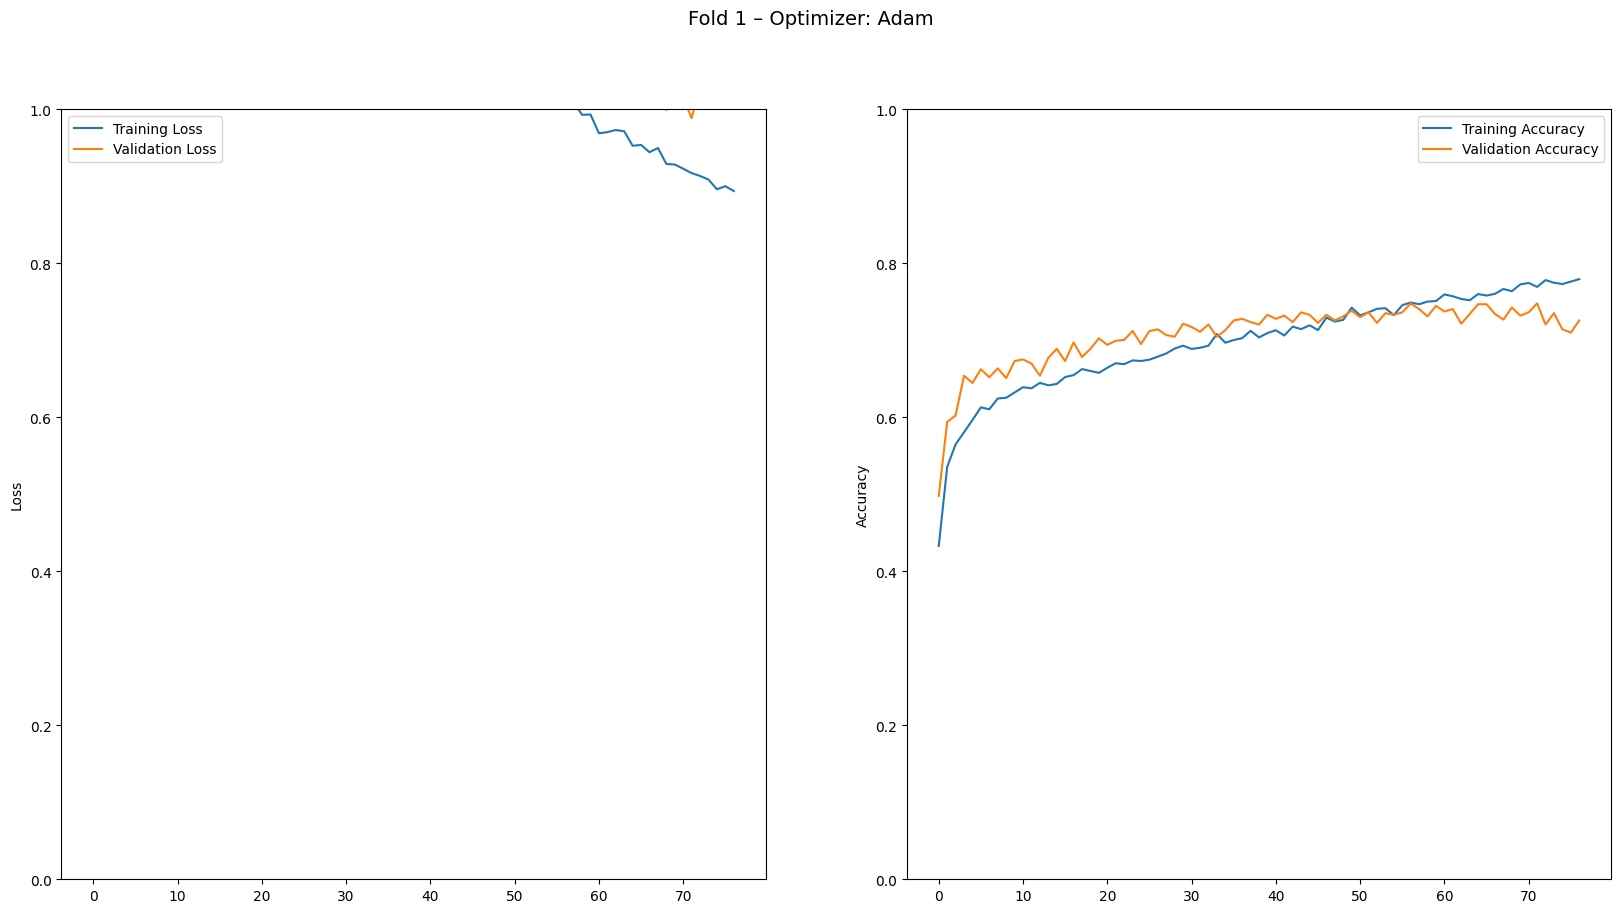

Fold 2/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4064 validated image filenames belonging to 4 classes.
Found 968 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 60s 435ms/step - accuracy: 0.3457 - loss: 2.5735 - val_accuracy: 0.5713 - val_loss: 2.3601
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.5172 - loss: 2.2217 - val_accuracy: 0.6178 - val_loss: 2.1410
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.5504 - loss: 2.0332 - val_accuracy: 0.6343 - val_loss: 1.9908
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.5951 - loss: 1.8804 - val_accuracy: 0.6384 - val_loss: 1.9033
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.5976 - loss: 1.7944 - val_accuracy: 0.6560 - val_loss: 1.7907
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 0.5943 - loss: 1.7397 - val_accuracy: 0.6539 - val_loss: 1.7194
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.6264 - loss: 1.6593 - val_accuracy: 0.6725 - val_loss: 1.6805
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.6331 -

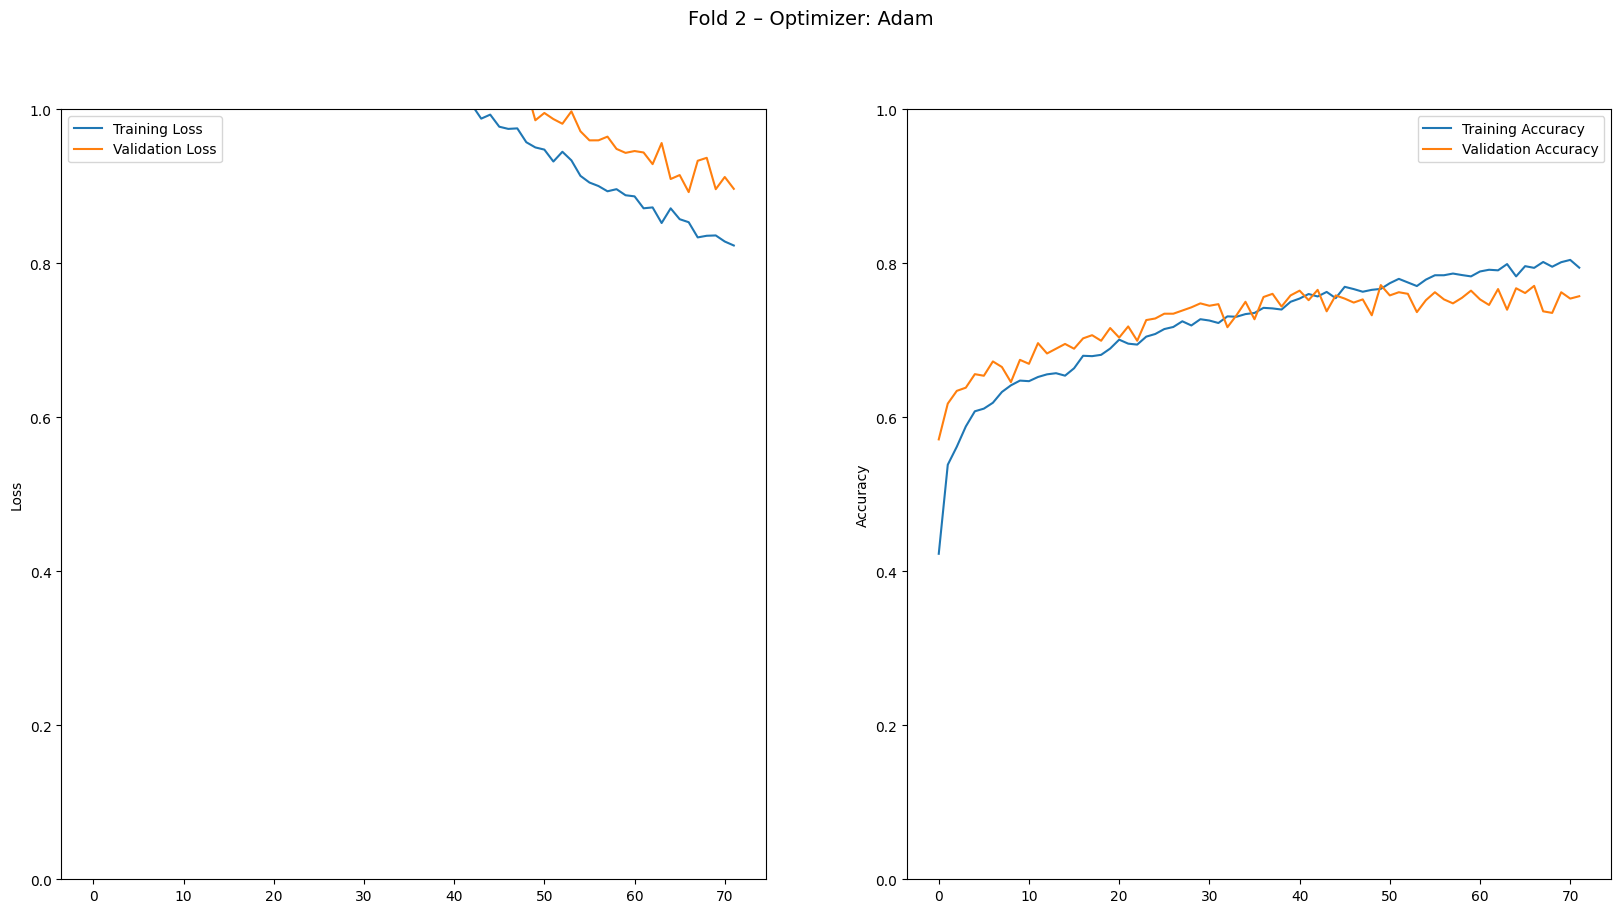

Fold 3/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4096 validated image filenames belonging to 4 classes.
Found 956 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 232ms/step - accuracy: 0.3520 - loss: 2.5747 - val_accuracy: 0.5251 - val_loss: 2.3759
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.5038 - loss: 2.2638 - val_accuracy: 0.6287 - val_loss: 2.1924
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.5662 - loss: 2.0721 - val_accuracy: 0.6276 - val_loss: 2.0600
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.5984 - loss: 1.9531 - val_accuracy: 0.6297 - val_loss: 1.9599
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - accuracy: 0.6157 - loss: 1.8779 - val_accuracy: 0.6161 - val_loss: 1.9073
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.6239 - loss: 1.8128 - val_accuracy: 0.6381 - val_loss: 1.8190
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.6133 - loss: 1.7630 - val_accuracy: 0.6433 - val_loss: 1.7911
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.6271 -

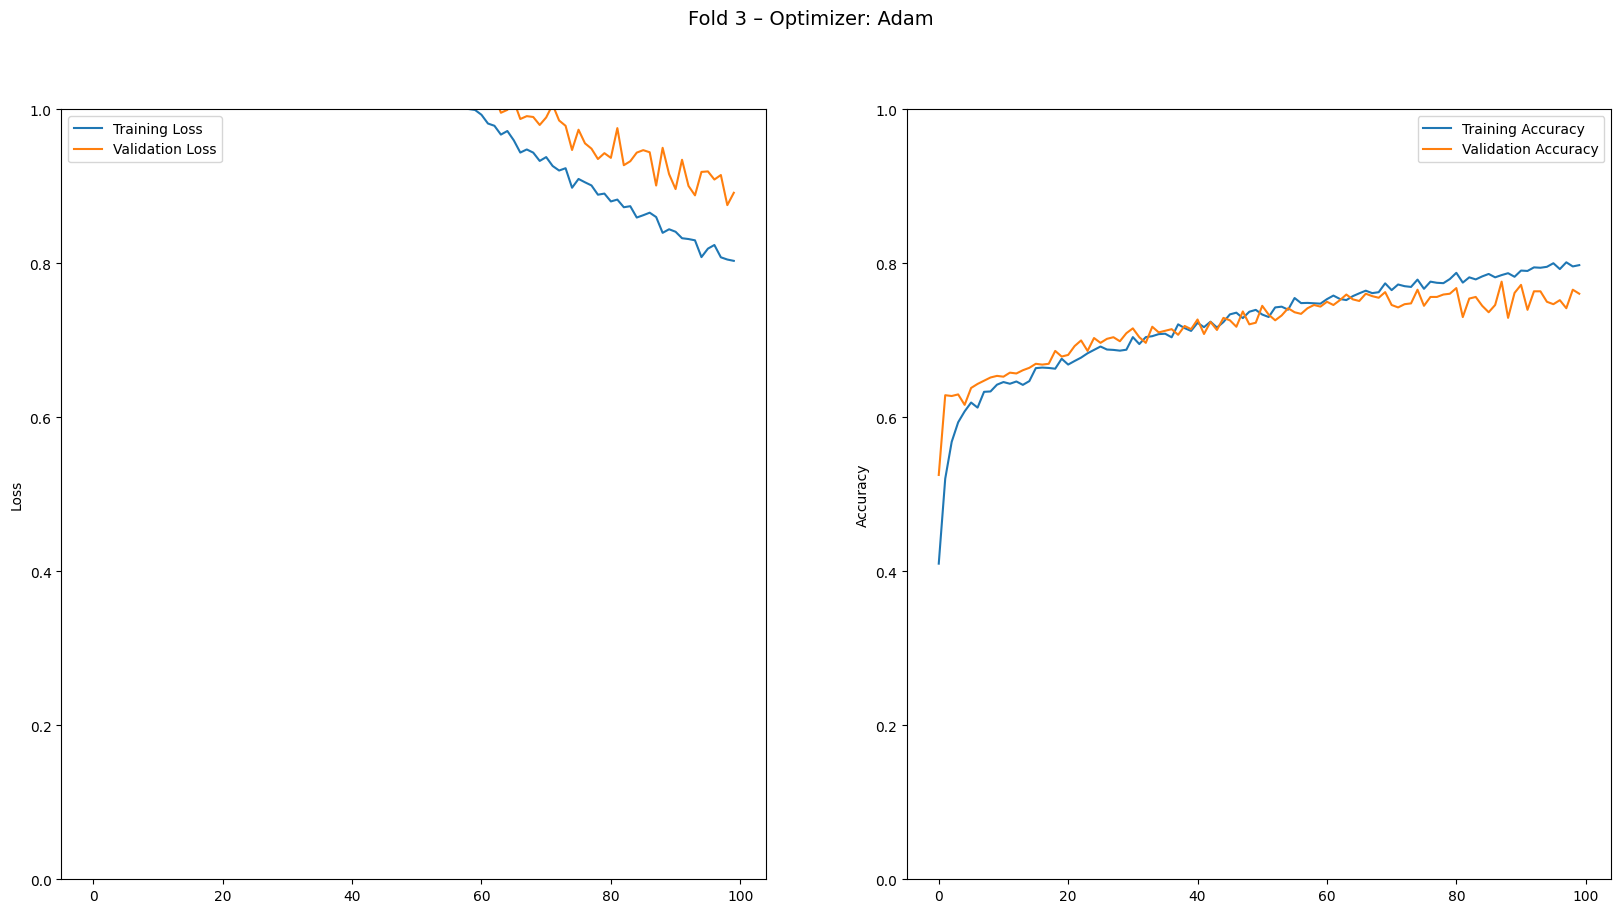

Fold 4/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4104 validated image filenames belonging to 4 classes.
Found 984 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 38s 257ms/step - accuracy: 0.3587 - loss: 2.5714 - val_accuracy: 0.5122 - val_loss: 2.3511
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.5323 - loss: 2.2294 - val_accuracy: 0.5518 - val_loss: 2.1909
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 47s 260ms/step - accuracy: 0.5688 - loss: 2.0753 - val_accuracy: 0.6148 - val_loss: 2.0777
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.5913 - loss: 1.9696 - val_accuracy: 0.6443 - val_loss: 1.9871
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 0.5981 - loss: 1.8911 - val_accuracy: 0.6413 - val_loss: 1.9112
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.6220 - loss: 1.8106 - val_accuracy: 0.6463 - val_loss: 1.8500
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - accuracy: 0.6211 - loss: 1.7519 - val_accuracy: 0.6270 - val_loss: 1.8091
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.6232 -

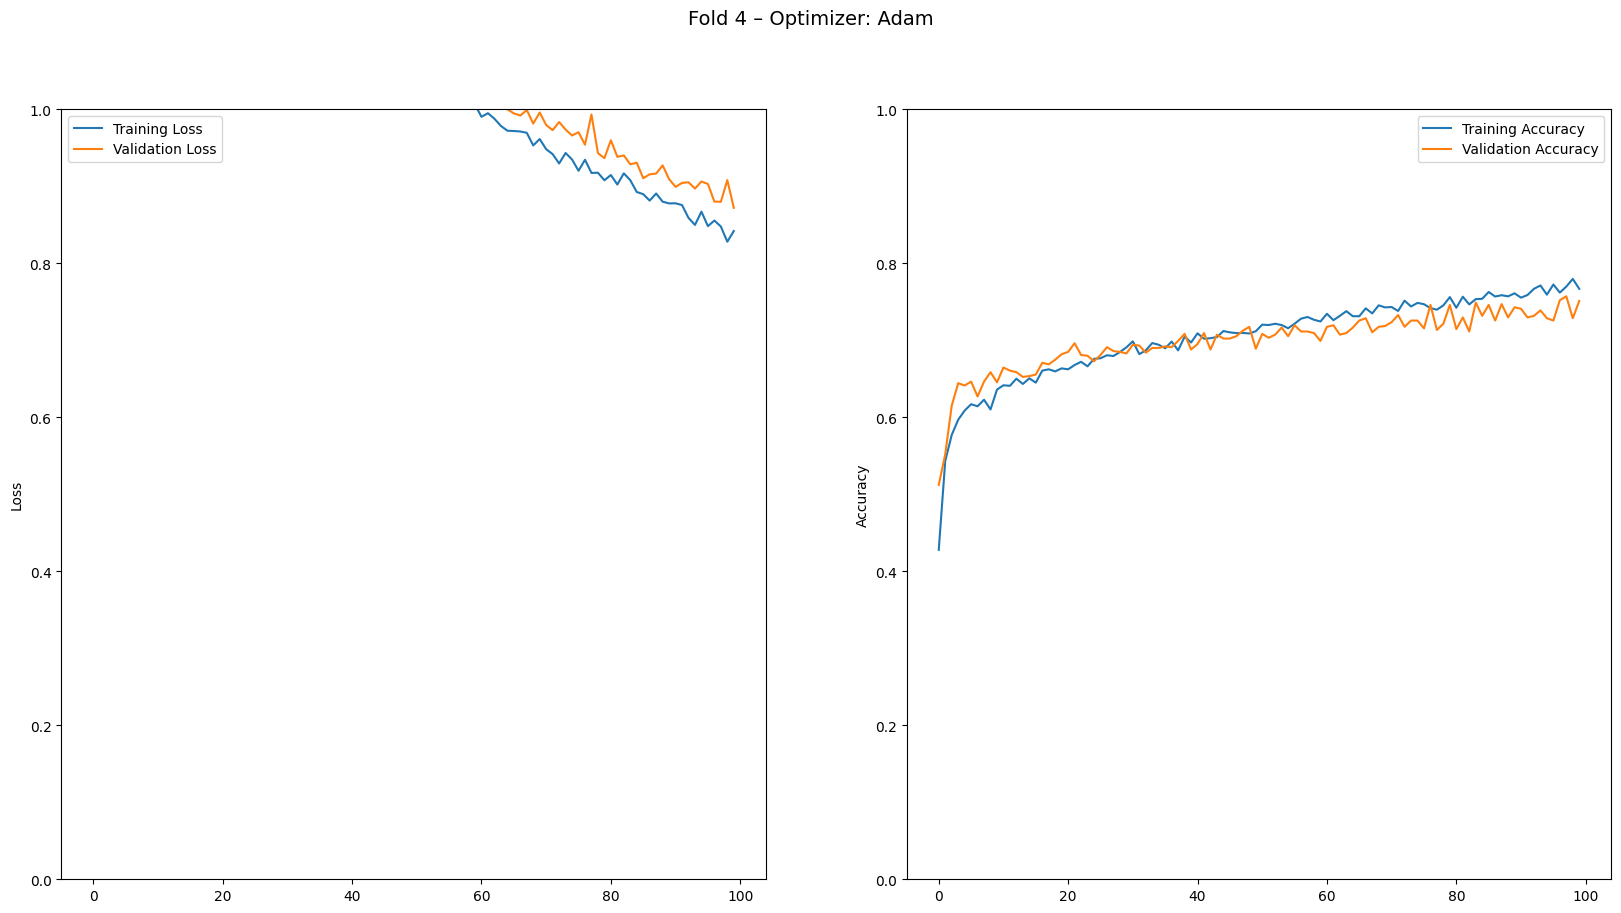

Fold 5/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4040 validated image filenames belonging to 4 classes.
Found 956 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.3473 - loss: 2.6047 - val_accuracy: 0.5471 - val_loss: 2.3993
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.5105 - loss: 2.2930 - val_accuracy: 0.6674 - val_loss: 2.2428
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.5453 - loss: 2.1686 - val_accuracy: 0.6517 - val_loss: 2.1448
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.5757 - loss: 2.0501 - val_accuracy: 0.6590 - val_loss: 2.0810
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 212ms/step - accuracy: 0.5822 - loss: 2.0196 - val_accuracy: 0.6810 - val_loss: 1.9774
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.5945 - loss: 1.9184 - val_accuracy: 0.6695 - val_loss: 1.9384
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.6176 - loss: 1.8413 - val_accuracy: 0.6663 - val_loss: 1.8838
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.6178 -

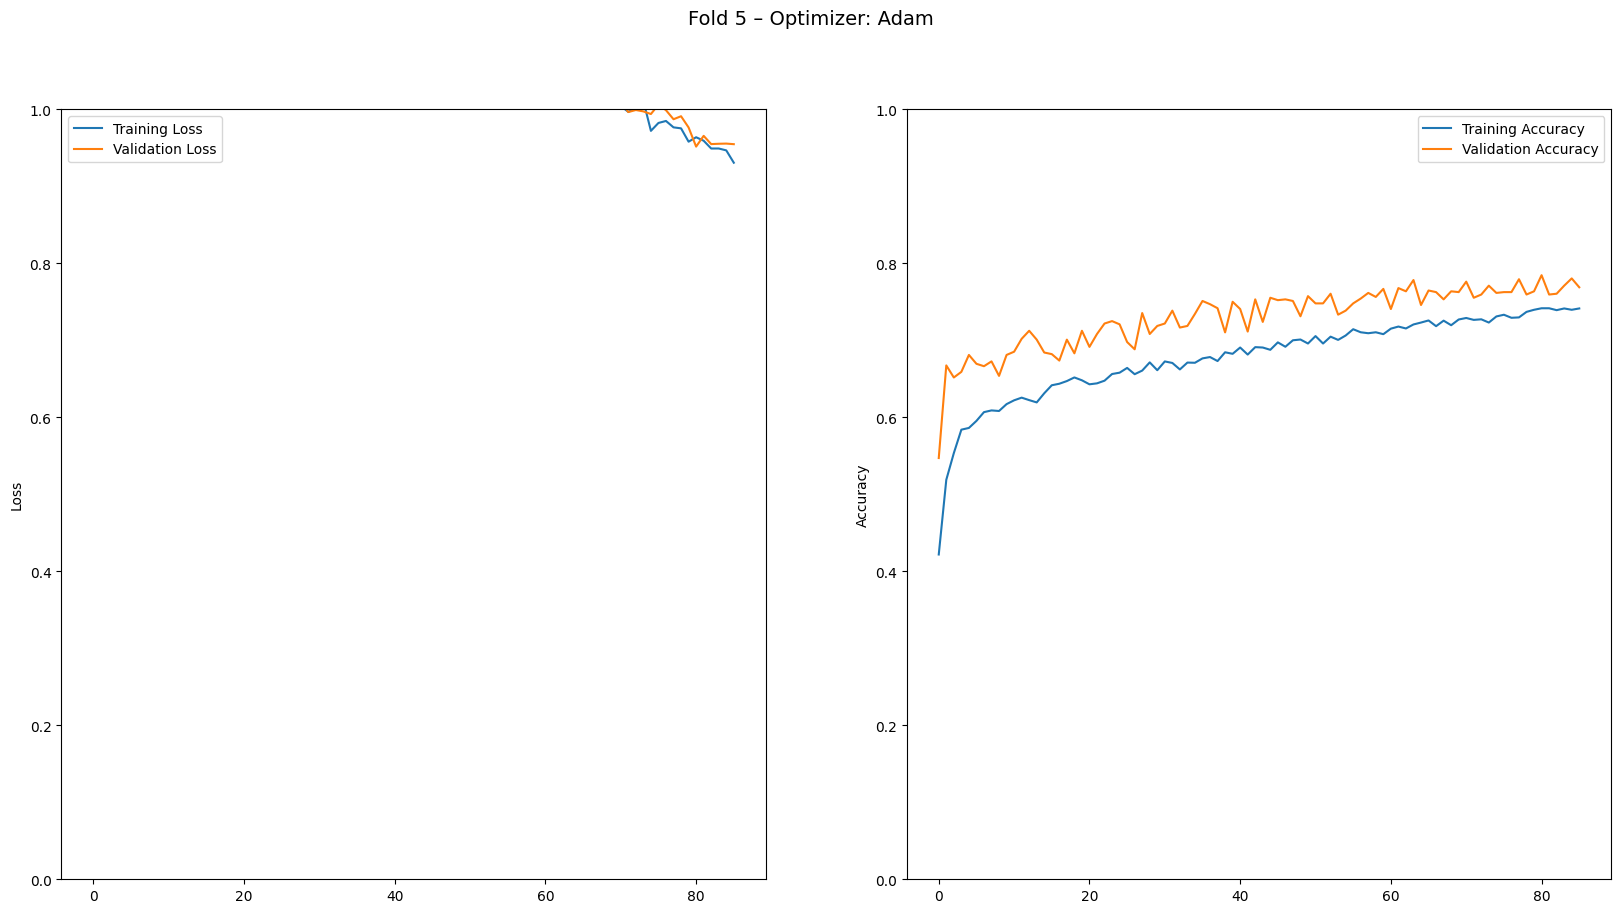


🎯 Moyenne des accuracies sur 5 folds : 0.7675


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (224, 224, 3)
batch_size = 32
epochs = 100
k_folds = 5
num_classes = 2

image_dir = "/content/drive/My Drive/COVID-19_Radiography_Dataset/train"

kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df_balanced)):
    print(f'Fold {fold+1}/{k_folds}')

    train_df = df_balanced.iloc[train_idx]
    val_df = df_balanced.iloc[val_idx]


    train_df_balanced = balance_dataframe(train_df)
    val_df_balanced = balance_dataframe(val_df)


    train_generator = datagen.flow_from_dataframe(
        train_df_balanced,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df_balanced,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )

    model = create_model()

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")

    # Courbes
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    plt.suptitle(f'Fold {fold+1} – Optimizer: Adam', fontsize=14)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.show()

import numpy as np

print(f'\n🎯 Moyenne des accuracies sur {k_folds} folds : {np.mean(fold_accuracies):.4f}')


# Train the model

Everything is set up, let's train our model now!

Our best model managed to obtain a validation accuracy of approximately 65%, which is quite good given the fact that our target class has 7 possible values!

At each epoch, Keras checks if our model performed better than during the previous epochs. If it is the case, the new best model weights are saved into a file. This will allow us to load directly the weights of our model without having to re-train it if we want to use it.

We also have to save the structure of our CNN (layers etc.) into a file:

In [ ]:
model.save('/content/drive/My Drive/covid_CNN.hdf5')
print("SAVED")

SAVED


# Analyze the results

We got outputs at each step of the training phase. All those outputs were saved into the 'history' variable. We can use it to plot the evolution of the loss and accuracy on both the train and validation datasets:

The validation accuracy starts to stabilize at the end of the 50 epochs between 60% and 65% accuracy.

The training loss is slightly higher than the validation loss for the first epochs which can be surprising. Indeed we are more used to see higher validation losses than training losses in machine learning. Here this is simply due to the presence of dropout, which is only applied during the training phase and not during the validation phase.

We can see that the training loss is becoming much smaller than the validation loss after the 20th epochs. This means that our model starts to overfit our training dataset after too much iterations. That is why the validation loss does not decrease a lot after. One solution consists in early-stopping the training of the model.

We could also use some different dropout values and performing data augmentation. Those methods were tested on this dataset, but they did not significantly increase the validation accuracy although they reduced the overfitting effect. Using them slightly increased the training duration of the model.

Finally we can plot the confusion matrix in order to see how our model classified the images:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

model = load_model("/content/drive/My Drive/covid_CNN.hdf5")

test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/COVID-19_Radiography_Dataset/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='categorical',
    shuffle=False
)

Found 8402 images belonging to 4 classes.


✅ Accuracy: 72.29%


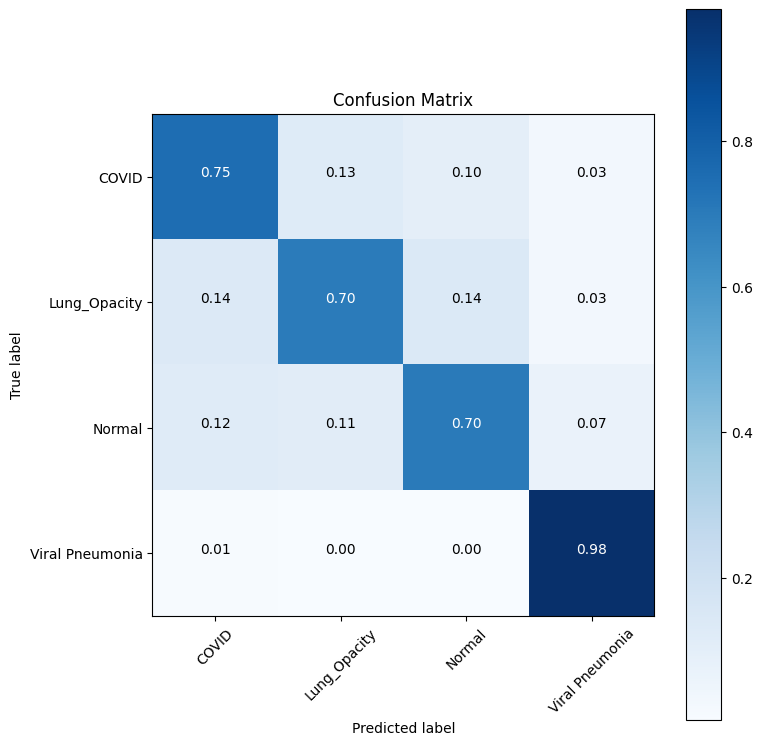

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Affiche la matrice de confusion normalisée"""
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# 🔄 Get predictions for the entire test set
y_pred = []
y_true = []
for i in range(len(test_generator)):
    X_test_batch, y_test_batch = test_generator[i]
    predictions_batch = model.predict(X_test_batch, verbose=0)
    y_pred_batch = np.argmax(predictions_batch, axis=1)
    y_true_batch = np.argmax(y_test_batch, axis=1)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_true_batch)

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# 🔹 Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

class_names = list(test_generator.class_indices.keys())

# 🔹 Affichage des résultats
print(f"✅ Accuracy: {accuracy * 100:.2f}%")
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')